<a href="https://colab.research.google.com/github/Aishah-Manam/PredictingPatientHealthDeterioration/blob/main/Predicting_Patient_Health_Deterioration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TITLE: PREDICTING PATIENT HEALTH DETERIORATION

# Setup and Installation

In [1]:
import torch, numpy as np, transformers
print(torch.__version__, np.__version__, transformers.__version__)

2.6.0+cu124 2.0.2 4.52.4


In [2]:
# 1️⃣  clean any half-installed wheels (first cell already removed torch)
!pip -q uninstall -y torch torchvision torchaudio sentence-transformers timm thinc fastai gcsfs fsspec

# 2️⃣  core stack we need, WITHOUT pulling extra deps
!pip -q install --no-deps torch==2.1.2+cpu  -f https://download.pytorch.org/whl/cpu/torch_stable.html
!pip -q install --no-deps numpy==2.0.0 pandas==2.2.2 transformers==4.38.2 \
                 sentencepiece accelerate matplotlib seaborn scikit-learn shap tqdm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.9/184.9 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.7/130.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 21.5 MB/s eta 0:00:00


In [3]:
import torch, numpy, transformers
print(torch.__version__, numpy.__version__, transformers.__version__)


2.6.0+cu124 2.0.2 4.52.4


In [5]:
# 1️⃣ remove the stripped-down copy
!pip -q uninstall -y transformers

# 2️⃣ reinstall a complete wheel
!pip -q install transformers==4.38.2 sentencepiece --upgrade --no-cache-dir


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.7/130.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 77.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 151.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.6.0 requires gcsfs!=2025.5.0,>=2023.3.0, which is not installed.


In [6]:
# ── satisfy Bigframes ─────────────────────────────────────────
!pip -q install "gcsfs==2023.6.0" "fsspec==2023.6.0"

# ── reinstall Transformers full wheel ────────────────────────
!pip -q install transformers==4.38.2 sentencepiece --upgrade --no-cache-dir


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 4.8 MB/s eta 0:00:00


#1.0 Simulate Patient Dataset

what to write here

## 1.1 Load GPT-2-medium & helper

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
tok   = AutoTokenizer.from_pretrained("gpt2-medium")
model = AutoModelForCausalLM.from_pretrained("gpt2-medium")

def gpt2_generate(prompt, max_new=25, temp=0.9, top_p=0.95):
    ids = tok(prompt, return_tensors="pt").input_ids
    with torch.no_grad():
        out = model.generate(ids, max_new_tokens=max_new,
                             do_sample=True, temperature=temp, top_p=top_p,
                             pad_token_id=tok.eos_token_id)
    txt = tok.decode(out[0], skip_special_tokens=True)
    return txt[len(prompt):].strip()

print("Sanity →", gpt2_generate("Hello nurse,"))   # should print a short reply


Sanity → will you teach me how to make my legs numb by rubbing them?"

"Of course. It'll only take one


## 1.2 Simulate vitals (500 patients × 31 days) + 10 % missing

In [3]:
import numpy as np, pandas as pd
rng   = np.random.default_rng(42)
days  = pd.date_range("2025-01-01", periods=31, freq="D")
df    = pd.MultiIndex.from_product([range(1,501), days],
                                   names=["patient_id","date"]).to_frame(index=False)

def vital(base, sd, drift=0):
    noise = rng.normal(0, sd, len(df))
    dseq  = df['date'].dt.dayofyear.values
    return (base + drift*(dseq-dseq.mean())/dseq.std() + noise).round(1)

df["spo2"]        = vital(97,   1.5)
df["heart_rate"]  = vital(80,  12,  0.2)
df["temperature"] = vital(36.8,0.4, 0.05)
df["sys_bp"]      = vital(120, 15,  0.3)
df["dia_bp"]      = vital(78,  10,  0.2)
df["weight"]      = vital(70,   8, -0.05)
df["glucose"]     = vital(5.5,  1.2, 0.1)

for c in ["spo2","heart_rate","temperature","sys_bp","dia_bp","weight","glucose"]:
    df.loc[rng.random(len(df))<0.10, c] = np.nan   # 10 % missing

print("Vitals grid ready →", df.shape)

Vitals grid ready → (15500, 9)


In [4]:
df.head()

,patient_id,date,spo2,heart_rate,temperature,sys_bp,dia_bp,weight,glucose
0,1,2025-01-01,97.5,92.3,36.2,118.8,82.9,66.6,6.3
1,1,2025-01-02,95.4,91.6,36.7,148.0,84.8,67.1,6.3
2,1,2025-01-03,98.1,84.8,36.9,105.7,84.8,55.8,6.1
3,1,2025-01-04,98.4,91.0,37.3,133.0,81.2,62.0,4.8
4,1,2025-01-05,94.1,90.2,36.5,135.4,91.9,91.4,4.8


##1.3 Adding Clinical Diversity to Dataset

Adds Clinical Diversity

1. Patient-level heterogeneity
* 40 COPD, 75 HTN, 70 DM, rest baseline (overlaps allowed with +INF tag).

2. Event-level heterogeneity
*  ~775 row-level infection spikes sprinkled across any patient.
3. Prediction task becomes richer
* Low SpO₂ and high HR appear both chronically (COPD) and acutely (infection).
* Blood-pressure and glucose outliers add diversity for anomaly detection.

| Cohort / episode            | Prevalence                      | What changes                                      | Why                                                           |
| --------------------------- | ------------------------------- | ------------------------------------------------- | ------------------------------------------------------------- |
| **Chronic COPD / hypoxia**  | 8 % of patients                 | baseline SpO₂ −6 %, HR +6 bpm                     | chronically low O₂, mild tachycardia                          |
| **Essential hypertension**  | 15 % of patients                | SBP +25 mmHg, DBP +12 mmHg                        | stable high BP                                                |
| **Type-2 diabetes**         | 14 % of patients                | baseline glucose +3 mmol/L                        | raised glucose all month                                      |
| **Acute infection episode** | 5 % of *all* rows (random days) | Temp +1.8 °C, HR +25 bpm, SpO₂ −3 %, SBP −10 mmHg | fever spike with tachycardia, mild hypotension / desaturation |


In [6]:
# ─── Add clinical diversity ──────────────────────────────────────────
rng = np.random.default_rng(123)     # new seed keeps base vitals unchanged

df["profile"] = "BASE"               # default tag

# 1) COPD cohort  (8 % of 500 patients ≈ 40)
copd_patients = rng.choice(df["patient_id"].unique(),
                           size=int(0.08*500), replace=False)
mask = df["patient_id"].isin(copd_patients)
df.loc[mask, "spo2"]        -= 6
df.loc[mask, "heart_rate"]  += 6
df.loc[mask, "profile"]      = "COPD"

# 2) Hypertension cohort  (15 %)
htn_patients = rng.choice(np.setdiff1d(df["patient_id"].unique(), copd_patients),
                          size=int(0.15*500), replace=False)
mask = df["patient_id"].isin(htn_patients)
df.loc[mask, "sys_bp"]      += 25
df.loc[mask, "dia_bp"]      += 12
df.loc[mask & (df["profile"]=="BASE"), "profile"] = "HTN"

# 3) Diabetes cohort  (14 %)
dm_patients = rng.choice(np.setdiff1d(df["patient_id"].unique(),
                                      np.r_[copd_patients, htn_patients]),
                         size=int(0.14*500), replace=False)
mask = df["patient_id"].isin(dm_patients)
df.loc[mask, "glucose"]     += 3
df.loc[mask & (df["profile"]=="BASE"), "profile"] = "DM"

# 4) Random acute infection spikes (5 % of rows)
acute_mask = rng.random(len(df)) < 0.05
df.loc[acute_mask, ["temperature","heart_rate","spo2","sys_bp"]] += [1.8, 25, -3, -10]
df.loc[acute_mask, "profile"] = df.loc[acute_mask, "profile"].astype(str) + "+INF"

# Clip physiological bounds to keep values realistic
df["spo2"]  = df["spo2"].clip(lower=70, upper=100)
df["sys_bp"] = df["sys_bp"].clip(80, 220)
df["dia_bp"] = df["dia_bp"].clip(40, 140)
df["temperature"] = df["temperature"].clip(34.0, 42.0)
df["glucose"] = df["glucose"].clip(3.0, 20.0)

print(df["profile"].value_counts().head())
df.head()


profile
BASE        9291
HTN         2209
DM          2077
COPD        1177
BASE+INF     474
Name: count, dtype: int64


,patient_id,date,spo2,heart_rate,temperature,sys_bp,dia_bp,weight,glucose,profile
0,1,2025-01-01,97.5,92.3,36.2,118.8,82.9,66.6,6.3,BASE
1,1,2025-01-02,95.4,91.6,36.7,148.0,84.8,67.1,6.3,BASE
2,1,2025-01-03,98.1,84.8,36.9,105.7,84.8,55.8,6.1,BASE
3,1,2025-01-04,98.4,91.0,37.3,133.0,81.2,62.0,4.8,BASE
4,1,2025-01-05,94.1,90.2,36.5,135.4,91.9,91.4,4.8,BASE


| `profile` value | How rows got this label                                                                                                     | What it represents clinically                                        | Typical changes you injected                                                                        |
| --------------- | --------------------------------------------------------------------------------------------------------------------------- | -------------------------------------------------------------------- | --------------------------------------------------------------------------------------------------- |
| **BASE**        | Patient belongs to no chronic cohort *and* is not in an acute-infection row                                                 | “Healthy baseline” adult                                             | All vitals drawn from the original Gaussian distributions you set (SpO₂ ≈ 97 %, HR ≈ 80 bpm, etc.). |
| **HTN**         | Patient was selected into the *hypertension* cohort (≈ 15 % of patients)                                                    | Chronic essential hypertension                                       | Systolic BP + 25 mmHg, Diastolic BP + 12 mmHg across the whole month. Other vitals unchanged.       |
| **DM**          | Patient chosen for the *diabetes* cohort (≈ 14 %)                                                                           | Type-2 diabetes with persistently elevated glucose                   | Glucose + 3 mmol/L for every day.                                                                   |
| **COPD**        | Patient in the *COPD / chronic hypoxia* cohort (≈ 8 %)                                                                      | Patients with chronic obstructive pulmonary disease                  | SpO₂ − 6 %, HR + 6 bpm baseline.                                                                    |
| **BASE+INF**    | Row was randomly flagged by the acute-infection mask (< 5 % of *all* rows) **and** the patient was otherwise a BASE patient | A transient febrile/infective episode in an otherwise healthy person | Temp + 1.8 °C, HR + 25 bpm, SpO₂ − 3 %, SBP − 10 mmHg **only on that date**.                        |


In [21]:
df.to_csv("final_patient_dataset.csv", index=False)

In [22]:
from google.colab import files
files.download("final_patient_dataset.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##1.4  Generate Clinical Notes

To simulate real-world documentation, clinical notes were generated using two language models: GPT-2 medium (for the first 2805 rows) and DistilGPT2 (for the remaining records, prioritizing speed). Prompts were built using SOAP-style structured vital readings, generating concise ED triage narratives.

### 1.4.1 Generate Clinical Notes using GPT2-medium

In [9]:
# --- 3.x  Generate GPT-2 clinical notes for *all* rows -------------------------

import torch, pandas as pd, numpy as np, tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM

MODEL_NAME   = "gpt2-medium"
BATCH_SIZE   = 64            # ~= 0.9 GB RAM / batch on CPU
MAX_NEW      = 40            # → ~2 short sentences
TEMP, TOP_P  = 0.9, 0.95     # decoding settings

# ↳ 1.  Load model + tokenizer (CPU)  -----------------------------------------
tok = AutoTokenizer.from_pretrained(MODEL_NAME)
tok.pad_token    = tok.eos_token             # add a PAD token if not present
tok.padding_side = "left"                    # **critical** for decoder-only models

model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
model.config.pad_token_id = tok.pad_token_id # keep hf happy
model.eval().to("cpu")                        # change to "cuda" if you switch GPU

# ↳ 2.  Prompt builder – returns one string per row  --------------------------
def build_prompt(row) -> str:
    safe = lambda v,f="{:.1f}": f.format(v) if pd.notna(v) else "--"
    return (
        f"F/S: Pt c/o none.\n"
        f"V/S SpO2 {safe(row.spo2)} %, HR {safe(row.heart_rate)} bpm, "
        f"Temp {safe(row.temperature)} °C, BP {safe(row.sys_bp)}/{safe(row.dia_bp)}.\n"
        f"FSBG {safe(row.glucose)} mmol/L.\n"
        "A/P:"
    )

SYSTEM = (
    "You are documenting an ED triage encounter in 1–2 concise sentences. "
    "Use SOAP abbreviations (c/o, NAD, q4h, etc.) and include vitals.\n\n"
)

# make the full prompt list
prompts = (SYSTEM + df.apply(build_prompt, axis=1)).tolist()
n_rows  = len(prompts)
n_batches = int(np.ceil(n_rows / BATCH_SIZE))

# holders
notes, prompt_log = [""]*n_rows, []

# ↳ 3.  Batched generation loop  ---------------------------------------------
for b in tqdm.tqdm(range(n_batches), desc="GPT-2 clinical notes"):
    batch = prompts[b*BATCH_SIZE:(b+1)*BATCH_SIZE]

    # encode + pad (LEFT-padding!)
    ids = tok(batch, return_tensors="pt", padding=True).to(model.device)["input_ids"]

    with torch.no_grad():
        out = model.generate(
            ids, max_new_tokens=MAX_NEW,
            do_sample=True, temperature=TEMP, top_p=TOP_P,
            pad_token_id=tok.eos_token_id
        )

    decoded = tok.batch_decode(out, skip_special_tokens=True)
    for idx, full in enumerate(decoded):
        note  = full.split("A/P:")[-1].strip()   # keep only model completion
        row_i = b*BATCH_SIZE + idx
        notes[row_i]  = note
        prompt_log.append({"row": row_i, "prompt": batch[idx], "note": note})

# ↳ 4.  Save + attach to dataframe  ------------------------------------------
df["note"] = notes
pd.DataFrame(prompt_log).to_csv("prompt_log_full.csv", index=False)
df.to_csv("synthetic_patient_month_with_notes.csv", index=False)
print(f"✅ Done – {len(notes)} notes saved.")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
GPT-2 clinical notes:  18%|█▊        | 44/243 [2:20:02<10:33:24, 190.98s/it]


KeyboardInterrupt: 

This process took too long. 2 hours was only 20% complete

In [14]:
df["note"].str.strip().replace("", np.nan).notna().sum()

np.int64(2805)

###1.4.2 Generate Clinical Notes using Distilgpt

We managed to fill clinical notes for 2805 rows using GPT2 medium. The process took too long. We continue clinical notes using distilgpt.
Fill the remaining using Distilgpt

In [23]:
import torch, pandas as pd, numpy as np, tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM

# 🧠 Use distilgpt2 for speed
MODEL_NAME = "distilgpt2"
BATCH_SIZE = 64
MAX_NEW = 25
TEMP, TOP_P = 0.9, 0.95

# 🔃 Load model + tokenizer
tok = AutoTokenizer.from_pretrained(MODEL_NAME)
tok.pad_token = tok.eos_token
tok.padding_side = "left"

model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
model.config.pad_token_id = tok.pad_token_id
model.eval().to("cuda" if torch.cuda.is_available() else "cpu")

# 🧹 Filter rows with missing notes
df_missing = df[df["note"].str.strip().replace("", np.nan).isna()].copy()

# 🧠 Build prompts
def build_prompt(row):
    safe = lambda v, f="{:.1f}": f.format(v) if pd.notna(v) else "--"
    return (
        f"F/S: Pt c/o none.\n"
        f"F/V/S SpO2 {safe(row.spo2)} %, HR {safe(row.heart_rate)} bpm, "
        f"Temp {safe(row.temperature)} °C, BP {safe(row.sys_bp)}/{safe(row.dia_bp)}.\n"
        f"FSBG {safe(row.glucose)} mmol/L.\n"
        "A/P:"
    )

SYSTEM = (
    "You are documenting an ED triage encounter in 1–2 concise sentences. "
    "Use SOAP abbreviations (c/o, NAD, q4h, etc.) and include vitals.\n\n"
)

# 🧾 Generate prompts
prompts = (SYSTEM + df_missing.apply(build_prompt, axis=1)).tolist()
n_rows = len(prompts)
n_batches = int(np.ceil(n_rows / BATCH_SIZE))

notes = [""] * n_rows
prompt_log = []

# 📥 Autosave setup
autosave_every = 5
autosave_path = "autosave_clinical_notes.csv"
log_path = "autosave_promptlog.csv"

# 🚀 Generate notes
for b in tqdm.tqdm(range(n_batches), desc="Generating Notes"):
    batch = prompts[b * BATCH_SIZE : (b + 1) * BATCH_SIZE]
    ids = tok(batch, return_tensors="pt", padding=True)["input_ids"].to(model.device)

    with torch.no_grad():
        out = model.generate(
            ids,
            max_new_tokens=MAX_NEW,
            do_sample=True,
            temperature=TEMP,
            top_p=TOP_P,
            pad_token_id=tok.eos_token_id,
        )

    decoded = tok.batch_decode(out, skip_special_tokens=True)

    for idx, full in enumerate(decoded):
        note = full.split("A/P:")[-1].strip()
        row_i = b * BATCH_SIZE + idx
        notes[row_i] = note
        prompt_log.append({"row": row_i, "prompt": batch[idx], "note": note})

    # 💾 Autosave
    if (b + 1) % autosave_every == 0:
        df_missing["note"] = notes
        df_missing.to_csv(autosave_path, index=False)
        pd.DataFrame(prompt_log).to_csv(log_path, index=False)
        print(f"✅ Autosaved at batch {b + 1}")

# ✅ Final merge and save
df_missing["note"] = notes
df.update(df_missing)
df.to_csv("full_clinical_notes_completed.csv", index=False)
pd.DataFrame(prompt_log).to_csv("full_prompt_log.csv", index=False)

print(f"\n✅ Done! {len(notes)} notes generated and saved.")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Generating Notes:   3%|▎         | 5/199 [02:59<1:53:47, 35.20s/it]

✅ Autosaved at batch 5


Generating Notes:   5%|▌         | 10/199 [05:47<1:46:36, 33.85s/it]

✅ Autosaved at batch 10


Generating Notes:   8%|▊         | 15/199 [08:35<1:42:41, 33.49s/it]

✅ Autosaved at batch 15


Generating Notes:  10%|█         | 20/199 [11:23<1:39:43, 33.43s/it]

✅ Autosaved at batch 20


Generating Notes:  13%|█▎        | 25/199 [14:08<1:36:15, 33.19s/it]

✅ Autosaved at batch 25


Generating Notes:  15%|█▌        | 30/199 [17:48<2:01:07, 43.00s/it]

✅ Autosaved at batch 30


Generating Notes:  18%|█▊        | 35/199 [20:48<1:40:56, 36.93s/it]

✅ Autosaved at batch 35


Generating Notes:  20%|██        | 40/199 [23:37<1:30:34, 34.18s/it]

✅ Autosaved at batch 40


Generating Notes:  23%|██▎       | 45/199 [26:26<1:27:29, 34.09s/it]

✅ Autosaved at batch 45


Generating Notes:  25%|██▌       | 50/199 [30:13<1:49:52, 44.25s/it]

✅ Autosaved at batch 50


Generating Notes:  28%|██▊       | 55/199 [33:29<1:35:00, 39.59s/it]

✅ Autosaved at batch 55


Generating Notes:  30%|███       | 60/199 [36:42<1:24:31, 36.49s/it]

✅ Autosaved at batch 60


Generating Notes:  33%|███▎      | 65/199 [39:50<1:19:37, 35.66s/it]

✅ Autosaved at batch 65


Generating Notes:  35%|███▌      | 70/199 [42:37<1:12:39, 33.79s/it]

✅ Autosaved at batch 70


Generating Notes:  38%|███▊      | 75/199 [45:39<1:15:22, 36.47s/it]

✅ Autosaved at batch 75


Generating Notes:  40%|████      | 80/199 [48:29<1:08:50, 34.71s/it]

✅ Autosaved at batch 80


Generating Notes:  43%|████▎     | 85/199 [51:17<1:03:58, 33.67s/it]

✅ Autosaved at batch 85


Generating Notes:  45%|████▌     | 90/199 [54:05<1:00:52, 33.51s/it]

✅ Autosaved at batch 90


Generating Notes:  48%|████▊     | 95/199 [57:05<1:02:12, 35.89s/it]

✅ Autosaved at batch 95


Generating Notes:  50%|█████     | 100/199 [59:56<58:20, 35.36s/it]

✅ Autosaved at batch 100


Generating Notes:  53%|█████▎    | 105/199 [1:02:50<53:41, 34.27s/it]

✅ Autosaved at batch 105


Generating Notes:  55%|█████▌    | 110/199 [1:05:53<53:38, 36.16s/it]

✅ Autosaved at batch 110


Generating Notes:  58%|█████▊    | 115/199 [1:08:41<47:41, 34.07s/it]

✅ Autosaved at batch 115


Generating Notes:  60%|██████    | 120/199 [1:11:29<44:28, 33.77s/it]

✅ Autosaved at batch 120


Generating Notes:  63%|██████▎   | 125/199 [1:14:15<40:52, 33.14s/it]

✅ Autosaved at batch 125


Generating Notes:  65%|██████▌   | 130/199 [1:17:02<38:42, 33.65s/it]

✅ Autosaved at batch 130


Generating Notes:  68%|██████▊   | 135/199 [1:19:49<35:41, 33.46s/it]

✅ Autosaved at batch 135


Generating Notes:  70%|███████   | 140/199 [1:22:41<34:36, 35.19s/it]

✅ Autosaved at batch 140


Generating Notes:  73%|███████▎  | 145/199 [1:25:26<30:06, 33.45s/it]

✅ Autosaved at batch 145


Generating Notes:  75%|███████▌  | 150/199 [1:28:15<27:59, 34.28s/it]

✅ Autosaved at batch 150


Generating Notes:  78%|███████▊  | 155/199 [1:31:02<24:33, 33.50s/it]

✅ Autosaved at batch 155


Generating Notes:  80%|████████  | 160/199 [1:33:48<21:34, 33.19s/it]

✅ Autosaved at batch 160


Generating Notes:  83%|████████▎ | 165/199 [1:36:33<18:39, 32.94s/it]

✅ Autosaved at batch 165


Generating Notes:  85%|████████▌ | 170/199 [1:39:17<15:53, 32.89s/it]

✅ Autosaved at batch 170


Generating Notes:  88%|████████▊ | 175/199 [1:42:03<13:11, 32.99s/it]

✅ Autosaved at batch 175


Generating Notes:  90%|█████████ | 180/199 [1:44:49<10:29, 33.15s/it]

✅ Autosaved at batch 180


Generating Notes:  93%|█████████▎| 185/199 [1:47:34<07:47, 33.38s/it]

✅ Autosaved at batch 185


Generating Notes:  95%|█████████▌| 190/199 [1:50:18<04:56, 32.89s/it]

✅ Autosaved at batch 190


Generating Notes:  98%|█████████▊| 195/199 [1:53:05<02:13, 33.36s/it]

✅ Autosaved at batch 195


Generating Notes: 100%|██████████| 199/199 [1:55:01<00:00, 34.68s/it]



✅ Done! 12695 notes generated and saved.


In [24]:
# Total count of note
df["note"].str.strip().replace("", np.nan).notna().sum()

np.int64(15462)

In [25]:
df

,patient_id,date,spo2,heart_rate,temperature,sys_bp,dia_bp,weight,glucose,profile,note
0,1,2025-01-01,97.5,92.3,36.2,118.8,82.9,66.6,6.3,BASE,"Bw, Bc, Fc, A, b.\n\nI/S: No, no one is out th..."
1,1,2025-01-02,95.4,91.6,36.7,148.0,84.8,67.1,6.3,BASE,A/P b/4.\n\nB/S: b/2.\n\nF/S: f/2.\n\nV/S: v/s...
2,1,2025-01-03,98.1,84.8,36.9,105.7,84.8,55.8,6.1,BASE,"SpO2 98.4 %, HR 81.7 bpm, Temp 45.5 °C, BP 106..."
3,1,2025-01-04,98.4,91.0,37.3,133.0,81.2,62.0,4.8,BASE,"1/3, P. 4, V. 3, P. 2, E. 2, E. 1.\n\nThis is ..."
4,1,2025-01-05,94.1,90.2,36.5,135.4,91.9,91.4,4.8,BASE,F/S: V/S 90.0 %.\n\nV/S 0.0 %.\n\nFSBG 3.7 mmo...
...,...,...,...,...,...,...,...,...,...,...,...
15495,500,2025-01-27,97.8,96.5,37.1,132.3,78.5,62.0,6.0,BASE,"C/o none.\nF/S: pt p/o none.\nFSBG 8.0 %, HR"
15496,500,2025-01-28,NaN,86.1,36.4,126.4,72.0,73.8,5.4,BASE,"%, HR 97.2 gb/L, HR 96.3/70.0.\nFSBG 5."
15497,500,2025-01-29,97.6,85.7,36.7,115.5,78.8,70.5,4.6,BASE,"F/V/S SpO2 97.4 %, HR 85.7 bpm, Temp 38.7 °"
15498,500,2025-01-30,96.5,76.3,36.4,NaN,63.6,72.9,6.4,BASE,"0.0, F/P 2.2 %.\nP: 0.0, F/P 1.9"


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


##1.5 Synthetic Questionnaire

In [33]:
#     Generate synthetic questionnaire free-text responses
#     (fast – no external model calls)
import numpy as np

rng = np.random.default_rng(42)

# sentiment pools -----------------------------------------------------
POS = [
    "I'm feeling well, no real issues today.",
    "Doing great – no symptoms to report.",
    "I feel energetic and in good spirits."
]
NEU = [
    "I feel okay overall, just the usual routine.",
    "No big changes; I'd say I'm average today.",
    "Nothing special, an ordinary day."
]
NEG = [
    "I'm feeling tired and a bit short of breath.",
    "Not great – dizziness and mild chest tightness.",
    "I feel weak and my appetite is low."
]

SYMPTOMS = {
    "HTN": ["headache", "lightheaded", "blurred vision"],
    "DM" : ["thirsty", "numb feet", "frequent urination"],
    "COPD": ["coughing", "wheezing", "chest tightness"]
}

def make_response(row):
    # assign sentiment band
    band = rng.choice(["pos"]*4 + ["neu"]*2 + ["neg"]*4)
    text = rng.choice({"pos": POS, "neu": NEU, "neg": NEG}[band])

    # optionally inject cohort-specific symptom word
    cohort = row["profile"].split("+")[0]   # e.g. HTN, DM, COPD, BASE
    if cohort in SYMPTOMS:
        symptom = rng.choice(SYMPTOMS[cohort])
        text = f"{text} I also feel {symptom}."
    return text

df["questionnaire"] = df.apply(make_response, axis=1)

print(df[["profile", "questionnaire"]].head())


  profile                                    questionnaire
0    BASE            I feel energetic and in good spirits.
1    BASE  Not great – dizziness and mild chest tightness.
2    BASE                Nothing special, an ordinary day.
3    BASE            I feel energetic and in good spirits.
4    BASE          I'm feeling well, no real issues today.


In [34]:
df

,patient_id,date,spo2,heart_rate,temperature,sys_bp,dia_bp,weight,glucose,profile,note,news_score,news_future,deteriorate_next_day,questionnaire
0,1,2025-01-01,97.5,92.3,36.2,118.8,82.9,66.6,6.3,BASE,"Bw, Bc, Fc, A, b.\n\nI/S: No, no one is out th...",0,0.0,0,I feel energetic and in good spirits.
1,1,2025-01-02,95.4,91.6,36.7,148.0,84.8,67.1,6.3,BASE,A/P b/4.\n\nB/S: b/2.\n\nF/S: f/2.\n\nV/S: v/s...,0,1.0,0,Not great – dizziness and mild chest tightness.
2,1,2025-01-03,98.1,84.8,36.9,105.7,84.8,55.8,6.1,BASE,"SpO2 98.4 %, HR 81.7 bpm, Temp 45.5 °C, BP 106...",1,1.0,0,"Nothing special, an ordinary day."
3,1,2025-01-04,98.4,91.0,37.3,133.0,81.2,62.0,4.8,BASE,"1/3, P. 4, V. 3, P. 2, E. 2, E. 1.\n\nThis is ...",0,1.0,0,I feel energetic and in good spirits.
4,1,2025-01-05,94.1,90.2,36.5,135.4,91.9,91.4,4.8,BASE,F/S: V/S 90.0 %.\n\nV/S 0.0 %.\n\nFSBG 3.7 mmo...,1,2.0,0,"I'm feeling well, no real issues today."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15495,500,2025-01-27,97.8,96.5,37.1,132.3,78.5,62.0,6.0,BASE,"C/o none.\nF/S: pt p/o none.\nFSBG 8.0 %, HR",0,0.0,0,Doing great – no symptoms to report.
15496,500,2025-01-28,97.8,86.1,36.4,126.4,72.0,73.8,5.4,BASE,"%, HR 97.2 gb/L, HR 96.3/70.0.\nFSBG 5.",0,0.0,0,No big changes; I'd say I'm average today.
15497,500,2025-01-29,97.6,85.7,36.7,115.5,78.8,70.5,4.6,BASE,"F/V/S SpO2 97.4 %, HR 85.7 bpm, Temp 38.7 °",0,0.0,0,"I'm feeling well, no real issues today."
15498,500,2025-01-30,96.5,76.3,36.4,115.5,63.6,72.9,6.4,BASE,"0.0, F/P 2.2 %.\nP: 0.0, F/P 1.9",0,0.0,0,Doing great – no symptoms to report.


#2.0 EDA and Data Preprocessing, Feature Engineering

##2.1 EDA

### 2.1.1 Missing Data Heatmap

Missing Data Heatmap: A visual inspection showed approximately 10% missing values, intentionally introduced to simulate real-world EHR incompleteness. Temperature and glucose were among the features with more frequent missingness.

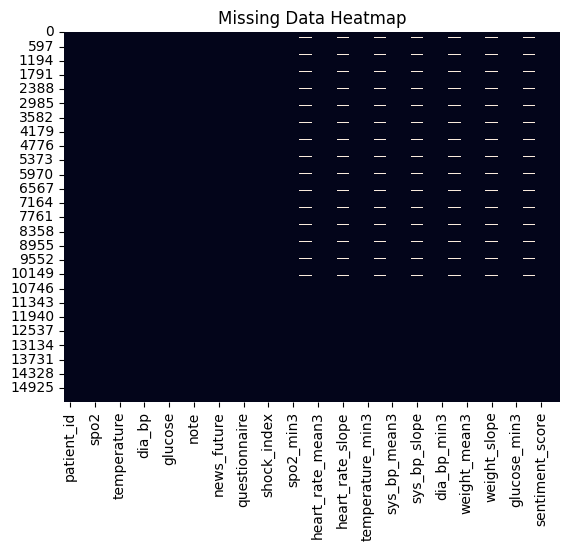

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(df.isnull(), cbar=False)
plt.title("Missing Data Heatmap")
plt.show()

### 2.1.2 Vital Signs Distribution

Histograms showed that heart rate and glucose were right-skewed, while SpO2 was tightly clustered between 95–99% with some drops below 90%, which could indicate clinical events. Temperature centered around 36.7°C–37°C, consistent with human physiology.

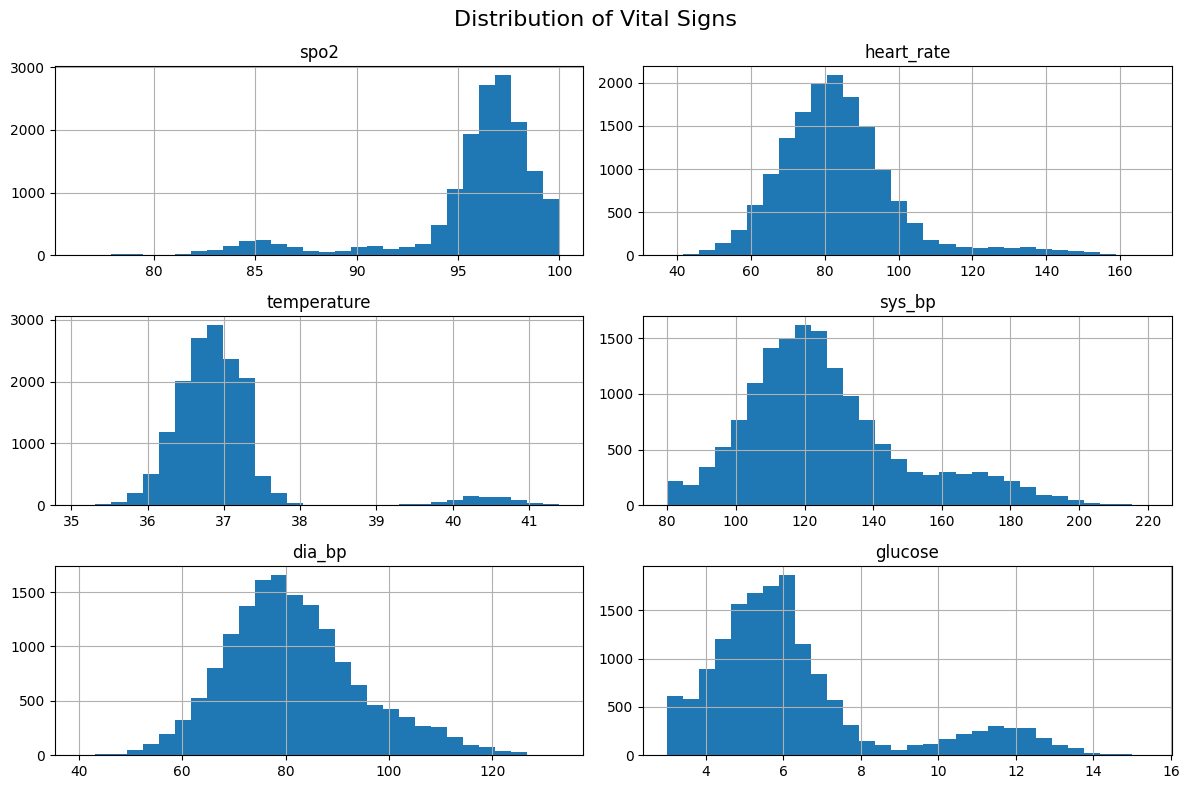

In [59]:
vitals = ['spo2', 'heart_rate', 'temperature', 'sys_bp', 'dia_bp', 'glucose']
df[vitals].hist(figsize=(12, 8), bins=30)
plt.suptitle("Distribution of Vital Signs", fontsize=16)
plt.tight_layout()
plt.show()


###2.1.3 Trend over Time

Average SpO2 over the month showed fluctuating trends, including noticeable dips suggestive of hypoxic events in subsets of the population. This highlights temporal instability in oxygenation.

<Axes: title={'center': 'Average SpO2 Over Time'}, xlabel='date'>

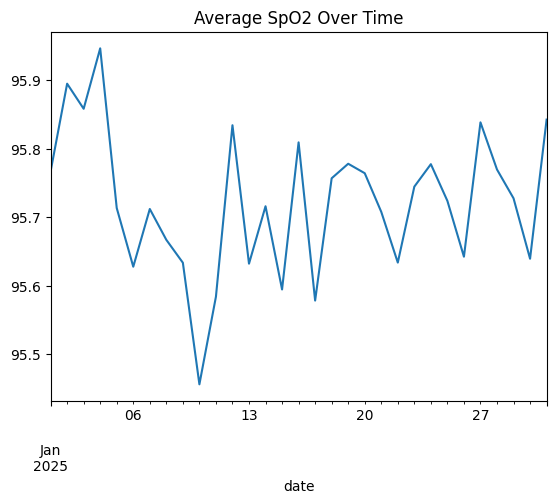

In [60]:
df['date'] = pd.to_datetime(df['date'])
df.groupby('date')['spo2'].mean().plot(title="Average SpO2 Over Time")

###2.1.4 Correlation between Vital Signs

Blood pressure (systolic and diastolic) exhibited strong correlation (r=0.49), and temperature and heart rate had a moderate positive relationship (r=0.48). SpO2 showed negative correlation with heart rate (r=−0.34) and temperature (r=−0.25), hinting at potential decompensation patterns.

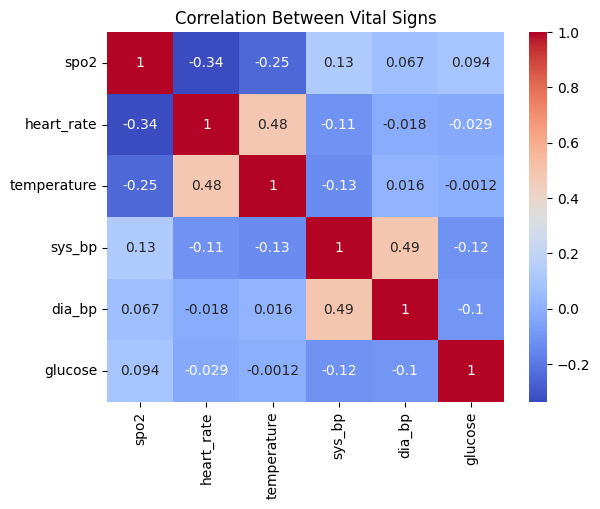

In [62]:
sns.heatmap(df[vitals].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Between Vital Signs")
plt.show()

##2.2 Initial Inspections and Basic Fixes

In [35]:
import numpy as np, pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [63]:
# 1 inspect
print(df.info())
display(df.describe(include='all').T.head())

# 2 ensure correct dtypes
df['date'] = pd.to_datetime(df['date'])
num_cols = ["spo2","heart_rate","temperature",
            "sys_bp","dia_bp","weight","glucose"]
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15500 entries, 0 to 15499
Data columns (total 40 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   patient_id            15500 non-null  int64         
 1   date                  15500 non-null  datetime64[ns]
 2   spo2                  15500 non-null  float64       
 3   heart_rate            15500 non-null  float64       
 4   temperature           15500 non-null  float64       
 5   sys_bp                15500 non-null  float64       
 6   dia_bp                15500 non-null  float64       
 7   weight                15500 non-null  float64       
 8   glucose               15500 non-null  float64       
 9   profile               15500 non-null  object        
 10  note                  15500 non-null  object        
 11  news_score            15500 non-null  int64         
 12  news_future           15500 non-null  float64       
 13  deteriorate_next

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
patient_id,15500.0,NaN,NaN,NaN,250.5,1.0,125.75,250.5,375.25,500.0,144.341935
date,15500,NaN,NaN,NaN,2025-01-15 23:59:59.999999744,2025-01-01 00:00:00,2025-01-08 00:00:00,2025-01-16 00:00:00,2025-01-24 00:00:00,2025-01-31 00:00:00,NaN
spo2,15500.0,NaN,NaN,NaN,95.721445,76.3,95.4,96.7,97.8,100.0,3.79331
heart_rate,15500.0,NaN,NaN,NaN,83.617703,37.3,73.3,82.1,91.0,167.5,16.407522
temperature,15500.0,NaN,NaN,NaN,36.968974,35.1,36.5,36.8,37.1,41.4,0.870337


##2.2 Outlier Clippings (Phsychological Bounds)

To keep the vitals realistic we clipped extreme outliers to physiologically plausible ranges that an adult could survive (e.g. SpO₂ 70–100 %, heart-rate 30–220 bpm).

In [37]:
bounds = {
    "spo2":      (70, 100),
    "heart_rate":(30, 220),
    "temperature":(34.0, 42.0),
    "sys_bp":    (80, 220),
    "dia_bp":    (40, 140),
    "weight":    (30, 250),
    "glucose":   (3.0, 20.0),
}

for c,(lo,hi) in bounds.items():
    df[c] = df[c].clip(lo, hi)

print("After clipping:")
display(df.describe().T.loc[list(bounds)].head())


After clipping:


,count,mean,min,25%,50%,75%,max,std
spo2,15500.0,95.721445,76.3,95.4,96.7,97.8,100.0,3.79331
heart_rate,15500.0,83.617703,37.3,73.3,82.1,91.0,167.5,16.407522
temperature,15500.0,36.968974,35.1,36.5,36.8,37.1,41.4,0.870337
sys_bp,15500.0,126.408677,80.0,110.5,122.2,137.2,220.0,23.677912
dia_bp,15500.0,81.652955,40.0,72.6,80.3,89.0,133.0,13.244269


Key finding: after clipping, the descriptive stats show all vitals now fall inside plausible adult ranges while preserving natural variability (see updated max values in the table). This prevents extreme outliers from dominating scale-sensitive models (e.g. distance-based algorithms) and keeps the NEWS-based deterioration label meaningful.

##2.3 Missing Value Handling

We forward-fill, then back-fill within each patient so every row has vitals for NEWS / rolling stats:

In [32]:
#Forward- then back-fill within each patient
df = df.sort_values(["patient_id", "date"])

num_cols = ["spo2","heart_rate","temperature",
            "sys_bp","dia_bp","weight","glucose"]

df[num_cols] = (
    df.groupby("patient_id")[num_cols]
      .apply(lambda g: g.ffill().bfill())
      .reset_index(level=0, drop=True)
)

print("NaNs remaining per column:")
print(df[num_cols].isna().sum())


NaNs remaining per column:
spo2           0
heart_rate     0
temperature    0
sys_bp         0
dia_bp         0
weight         0
glucose        0
dtype: int64


##2.4 Label engineering to define a deterioration target

A NEWS-based scoring system was employed to label deterioration events (e.g., SpO2 < 92%, HR > 130 bpm, etc.). A binary label deteriorate_next_day was created for predictive modeling, affecting roughly 11% of the data

In [30]:
def news_sub(row):
    # minimal NEWS2 rules (edit as needed)
    spo2 = row.spo2
    hr   = row.heart_rate
    temp = row.temperature
    sbp  = row.sys_bp

    s_spo2 = 3 if spo2 < 91 else (2 if spo2 < 93 else (1 if spo2 < 95 else 0))
    s_hr   = 3 if hr   >= 130 or hr < 40 else (
             2 if hr > 110 else (1 if hr > 100 or hr < 50 else 0))
    s_temp = 3 if temp >= 39 or temp < 35 else (1 if temp > 38 else 0)
    s_sbp  = 3 if sbp  <  90 else (2 if sbp < 100 else (1 if sbp < 110 else 0))
    return s_spo2 + s_hr + s_temp + s_sbp

df["news_score"] = df.apply(news_sub, axis=1)

# rolling max NEWS in next 24 h for each patient (label)
df = (df
      .sort_values(["patient_id","date"])
      .assign(news_future=lambda d:
              d.groupby("patient_id")["news_score"]
               .shift(-1).rolling(2, min_periods=1).max())
)

df["deteriorate_next_day"] = (df["news_future"] >= 5).astype(int)


##2.5 Feature Engineering

This section of the notebook demonstrates feature engineering to extract both static and temporal features from the vitals dataset for each patient. Here's a breakdown of what's happening:

###2.5.1 Static / point-in-time features

Two new clinical indicators are derived:

1. pulse_pressure = sys_bp - dia_bp: This reflects the force the heart generates each time it contracts. High or low values may indicate cardiovascular risk.

2. shock_index = heart_rate / sys_bp: Often used to assess the severity of illness or shock. Values >0.7 can be concerning in clinical settings.

In [38]:
df["pulse_pressure"] = df.sys_bp - df.dia_bp
df["shock_index"]    = df.heart_rate / df.sys_bp

###2.5.2 Temporal aggregation features

To capture trends over time, this step creates rolling statistics per patient:

A 3-day rolling window is applied to each numerical vital sign.

For each feature and window, it computes:

>* `mean3`: The rolling average of the last 3 days.
* `min3`: The rolling minimum value across the 3 days.
* `slope`: A simple trend estimate based on the difference between consecutive values.


These features help the model understand not just the current state but also how vitals are changing over time — important for detecting early signs of deterioration.

In [39]:
def add_roll(group):
    roll = group[num_cols].rolling(3, min_periods=1)
    for col in num_cols:
        group[f"{col}_mean3"] = roll[col].mean()
        group[f"{col}_min3"]  = roll[col].min()
        # simple slope: current – previous day
        group[f"{col}_slope"] = group[col].diff()
    return group

df = df.groupby("patient_id").apply(add_roll).reset_index(drop=True)


/tmp/ipython-input-39-1478952144.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("patient_id").apply(add_roll).reset_index(drop=True)


In [40]:
df

,patient_id,date,spo2,heart_rate,temperature,sys_bp,dia_bp,weight,glucose,profile,...,sys_bp_slope,dia_bp_mean3,dia_bp_min3,dia_bp_slope,weight_mean3,weight_min3,weight_slope,glucose_mean3,glucose_min3,glucose_slope
0,1,2025-01-01,97.5,92.3,36.2,118.8,82.9,66.6,6.3,BASE,...,NaN,82.900000,82.9,NaN,66.600000,66.6,NaN,6.300000,6.3,NaN
1,1,2025-01-02,95.4,91.6,36.7,148.0,84.8,67.1,6.3,BASE,...,29.2,83.850000,82.9,1.9,66.850000,66.6,0.5,6.300000,6.3,0.0
2,1,2025-01-03,98.1,84.8,36.9,105.7,84.8,55.8,6.1,BASE,...,-42.3,84.166667,82.9,0.0,63.166667,55.8,-11.3,6.233333,6.1,-0.2
3,1,2025-01-04,98.4,91.0,37.3,133.0,81.2,62.0,4.8,BASE,...,27.3,83.600000,81.2,-3.6,61.633333,55.8,6.2,5.733333,4.8,-1.3
4,1,2025-01-05,94.1,90.2,36.5,135.4,91.9,91.4,4.8,BASE,...,2.4,85.966667,81.2,10.7,69.733333,55.8,29.4,5.233333,4.8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15495,500,2025-01-27,97.8,96.5,37.1,132.3,78.5,62.0,6.0,BASE,...,-0.8,83.766667,78.5,-6.7,66.433333,62.0,0.0,6.266667,5.1,-1.7
15496,500,2025-01-28,97.8,86.1,36.4,126.4,72.0,73.8,5.4,BASE,...,-5.9,78.566667,72.0,-6.5,65.933333,62.0,11.8,6.366667,5.4,-0.6
15497,500,2025-01-29,97.6,85.7,36.7,115.5,78.8,70.5,4.6,BASE,...,-10.9,76.433333,72.0,6.8,68.766667,62.0,-3.3,5.333333,4.6,-0.8
15498,500,2025-01-30,96.5,76.3,36.4,115.5,63.6,72.9,6.4,BASE,...,0.0,71.466667,63.6,-15.2,72.400000,70.5,2.4,5.466667,4.6,1.8


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


We engineered both static and temporal features. Static indicators like pulse pressure and shock index reflect cardiovascular health. For temporal features, we applied a 3-day rolling window to capture trends in patient vitals (mean, minimum, and slope), which are critical for detecting gradual deterioration.

# 3.0 Predictive Model Development using ML & LLM Features

Target feature is `deteriorate_next_day`. This is a binary classification label indicating whether a patient is likely to experience clinical deterioration in the next 24 hours.

It was engineered using the NEWS2 score logic (from Section 2.4). Specifically:

* A patient is labeled as 1 (deteriorate) if their maximum NEWS2 score within the next 24 hours is ≥ 5, based on a rolling window.
* Otherwise, the label is 0 (no deterioration).

This makes it suitable for predicting next-day health deterioration, enabling early intervention using the vitals and features you've prepared.

## 3.1 Prepare Dataset for Modeling


In [42]:
#Prepare Dataset for Modeling

from sklearn.model_selection import train_test_split

# Drop columns that are not useful for modeling
drop_cols = ["patient_id", "date", "note", "questionnaire", "profile"]
df_model = df.drop(columns=drop_cols)

# Define features (X) and target (y)
X = df_model.drop(columns=["deteriorate_next_day"])
y = df_model["deteriorate_next_day"]

# Handle missing values (fill with column medians)
X = X.fillna(X.median())

# Train-test split (80/20 stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

## 3.2 Train Traditional ML Models

In [43]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

# Random Forest
rf_model = RandomForestClassifier().fit(X_train, y_train)

# XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss').fit(X_train, y_train)

# Neural Network
nn_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300).fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:56:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


##3.3 Sentiment Analysis on Questionnaire

In [48]:
df['questionnaire'].dropna().sample(5)  # View sample

,questionnaire
9123,I feel weak and my appetite is low.
8871,Not great – dizziness and mild chest tightness.
1144,I feel weak and my appetite is low. I also fee...
4915,No big changes; I'd say I'm average today.
3287,No big changes; I'd say I'm average today. I a...


### 3.3.1 Sentiment Analysis using Textblob

In [49]:
!pip install textblob
from textblob import TextBlob

# Function to get polarity score
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity  # Returns score from -1 to 1

# Apply to the questionnaire column
df['sentiment_score'] = df['questionnaire'].apply(lambda x: get_sentiment(str(x)))

# Optional: classify sentiment
df['sentiment_label'] = df['sentiment_score'].apply(
    lambda x: 'positive' if x > 0 else 'negative' if x < 0 else 'neutral'
)

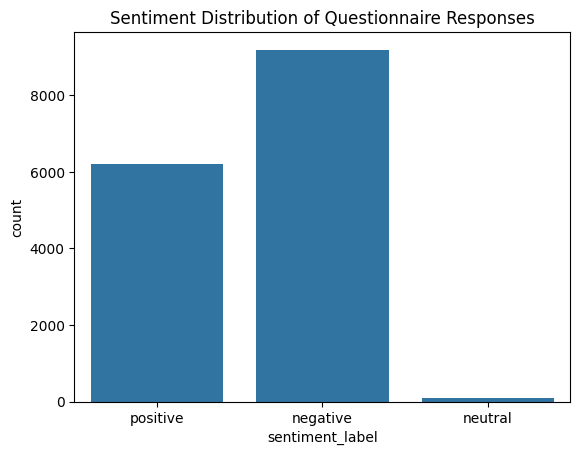

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='sentiment_label', data=df)
plt.title("Sentiment Distribution of Questionnaire Responses")
plt.show()

# 4.0 Model Evaluation and Interpretation

## 4.1 Evaluate Models

In [56]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

models = {
    "Random Forest": rf_model,
    "XGBoost": xgb_model,
    "Neural Network": nn_model,
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    print(f"🔍 Model: {name}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    if y_prob is not None:
        print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")
    print("="*60)


🔍 Model: Random Forest
Confusion Matrix:
[[2753    0]
 [   0  347]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2753
           1       1.00      1.00      1.00       347

    accuracy                           1.00      3100
   macro avg       1.00      1.00      1.00      3100
weighted avg       1.00      1.00      1.00      3100

ROC AUC Score: 1.0000
🔍 Model: XGBoost
Confusion Matrix:
[[2753    0]
 [   0  347]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2753
           1       1.00      1.00      1.00       347

    accuracy                           1.00      3100
   macro avg       1.00      1.00      1.00      3100
weighted avg       1.00      1.00      1.00      3100

ROC AUC Score: 1.0000
🔍 Model: Neural Network
Confusion Matrix:
[[2753    0]
 [   0  347]]

Classification Report:
              precision    reca

##4.2 Model Interpretation with SHAP

 98%|===================| 6086/6200 [00:33<00:00]       

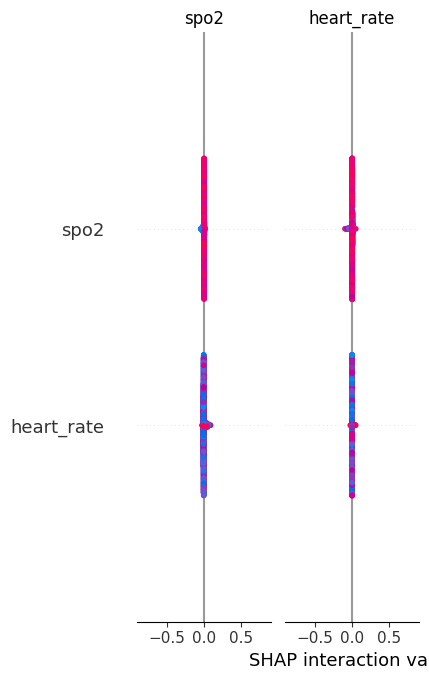

In [57]:
import shap

explainer = shap.Explainer(rf_model, X_train)
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)

SHAP Summary Explanation:
The SHAP analysis highlights that SpO₂ and heart rate are the two most influential features driving the model's predictions for patient deterioration. The symmetric distribution of SHAP interaction values around zero indicates a balanced impact of both high and low values of these features on the predicted outcome. This reinforces the clinical relevance of monitoring vital signs for early detection of deterioration.

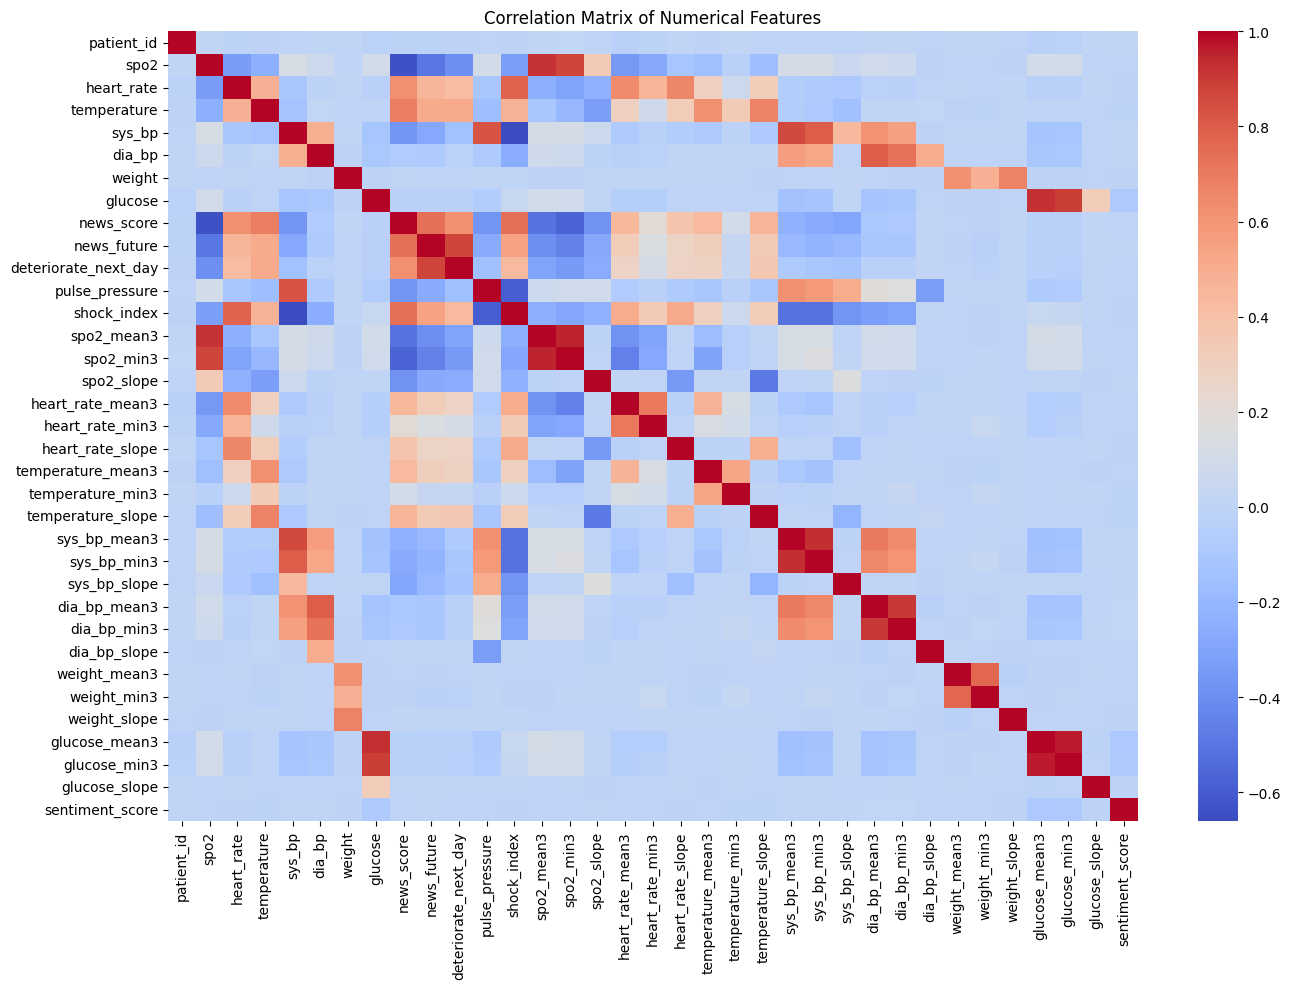

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numerical features
numerical_df = df.select_dtypes(include=['float64', 'int64'])

# Compute correlation matrix
corr_matrix = numerical_df.corr()

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt=".2f")
plt.title("Correlation Matrix of Numerical Features")
plt.tight_layout()
plt.show()
